In [37]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['hmnist_28_28_RGB.csv', 'hmnist_28_28_L.csv', 'ham10000_images_part_2', 'ham10000_images_part_1', 'hmnist_8_8_RGB.csv', 'HAM10000_metadata.csv', 'hmnist_8_8_L.csv']


In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

In [39]:
base_skin_dir = os.path.join('..', 'input')

# Merge images from both folders into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [40]:
tile_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Create some new columns (path to image, human-readable name) and review them

tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get) 
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes
tile_df.sample(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
674,HAM_0007029,ISIC_0030608,bkl,histo,45.0,male,back,../input/ham10000_images_part_2/ISIC_0030608.jpg,Benign keratosis-like lesions,2
4526,HAM_0002524,ISIC_0026184,nv,follow_up,55.0,male,trunk,../input/ham10000_images_part_1/ISIC_0026184.jpg,Melanocytic nevi,4
712,HAM_0000893,ISIC_0024825,bkl,histo,70.0,male,lower extremity,../input/ham10000_images_part_1/ISIC_0024825.jpg,Benign keratosis-like lesions,2
5862,HAM_0003858,ISIC_0031356,nv,follow_up,50.0,female,trunk,../input/ham10000_images_part_2/ISIC_0031356.jpg,Melanocytic nevi,4
6570,HAM_0005444,ISIC_0025745,nv,follow_up,40.0,female,lower extremity,../input/ham10000_images_part_1/ISIC_0025745.jpg,Melanocytic nevi,4
8294,HAM_0004432,ISIC_0030466,nv,histo,25.0,male,abdomen,../input/ham10000_images_part_2/ISIC_0030466.jpg,Melanocytic nevi,4
2692,HAM_0005842,ISIC_0027601,bcc,histo,75.0,female,back,../input/ham10000_images_part_1/ISIC_0027601.jpg,Basal cell carcinoma,1
9502,HAM_0004071,ISIC_0032607,nv,consensus,45.0,male,abdomen,../input/ham10000_images_part_2/ISIC_0032607.jpg,Melanocytic nevi,4
4112,HAM_0001636,ISIC_0030866,nv,follow_up,50.0,female,upper extremity,../input/ham10000_images_part_2/ISIC_0030866.jpg,Melanocytic nevi,4
425,HAM_0000782,ISIC_0030723,bkl,histo,75.0,female,face,../input/ham10000_images_part_2/ISIC_0030723.jpg,Benign keratosis-like lesions,2


In [41]:
input_dims = (56, 56)
input_shape = input_dims + (3,)
tile_df['image'] = tile_df['path'].map(lambda x: np.asarray(Image.open(x).resize(input_dims)))


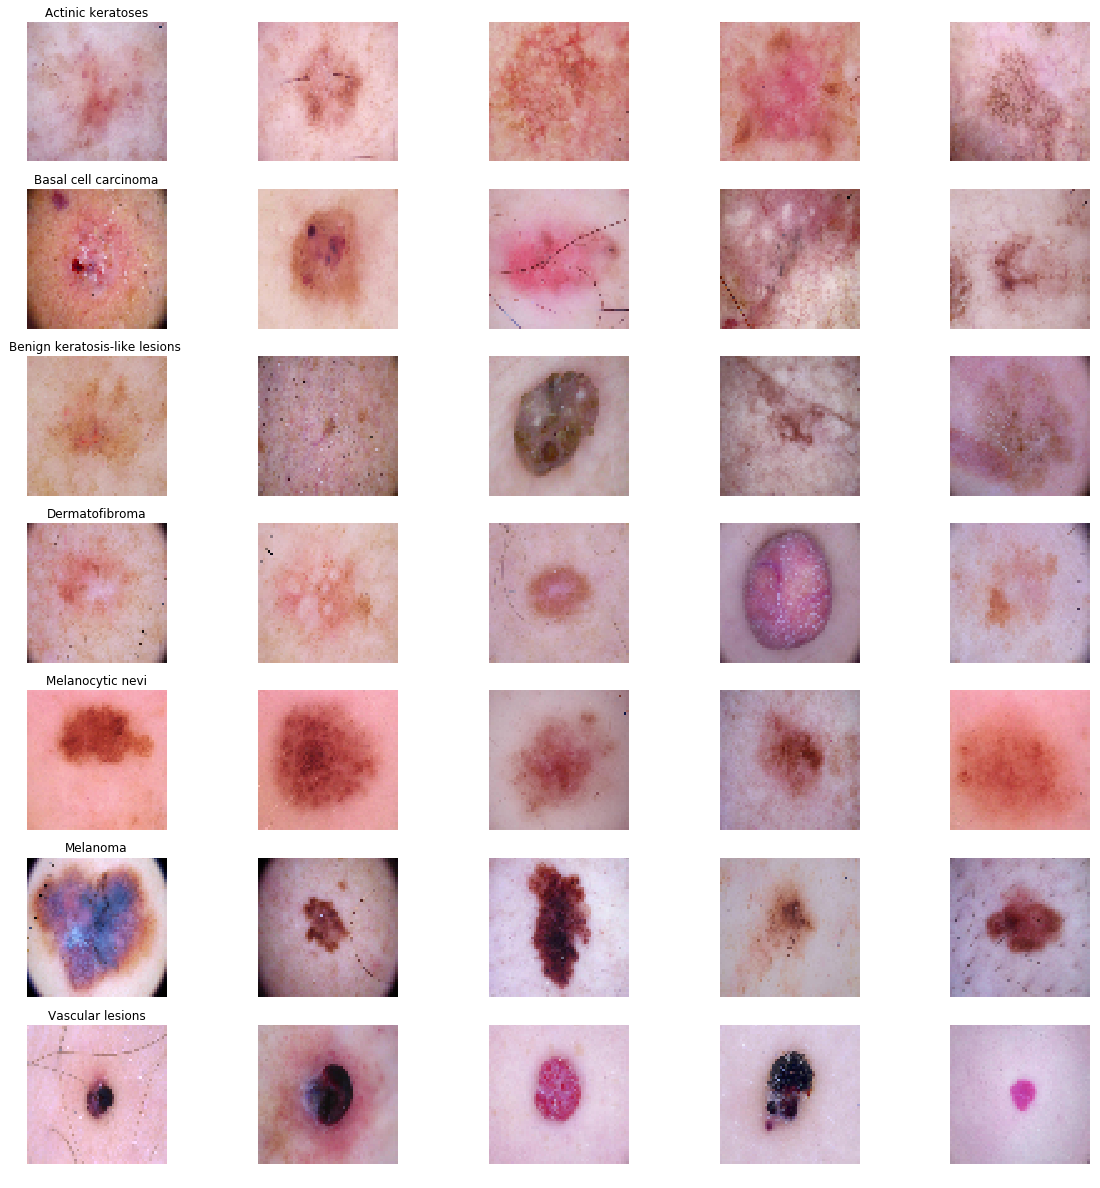

In [42]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         tile_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [43]:
tile_df['image'].map(lambda x: x.shape).value_counts()


(56, 56, 3)    10015
Name: image, dtype: int64

In [44]:
tile_df = tile_df.sample(frac=1)

# Training and test set division
train = tile_df[:-500]
test = tile_df[-500:]

In [45]:
x_train = np.asarray(train['image'].tolist()).reshape((train.shape[0],)+input_shape) #/ 255
x_test = np.asarray(test['image'].tolist()).reshape((test.shape[0],)+input_shape) #/ 255

y_train = train['cell_type_idx']
y_test = test['cell_type_idx']

# Perform one-hot encoding on the labels
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)

In [46]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True, 
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=True)
datagen.fit(x_train)

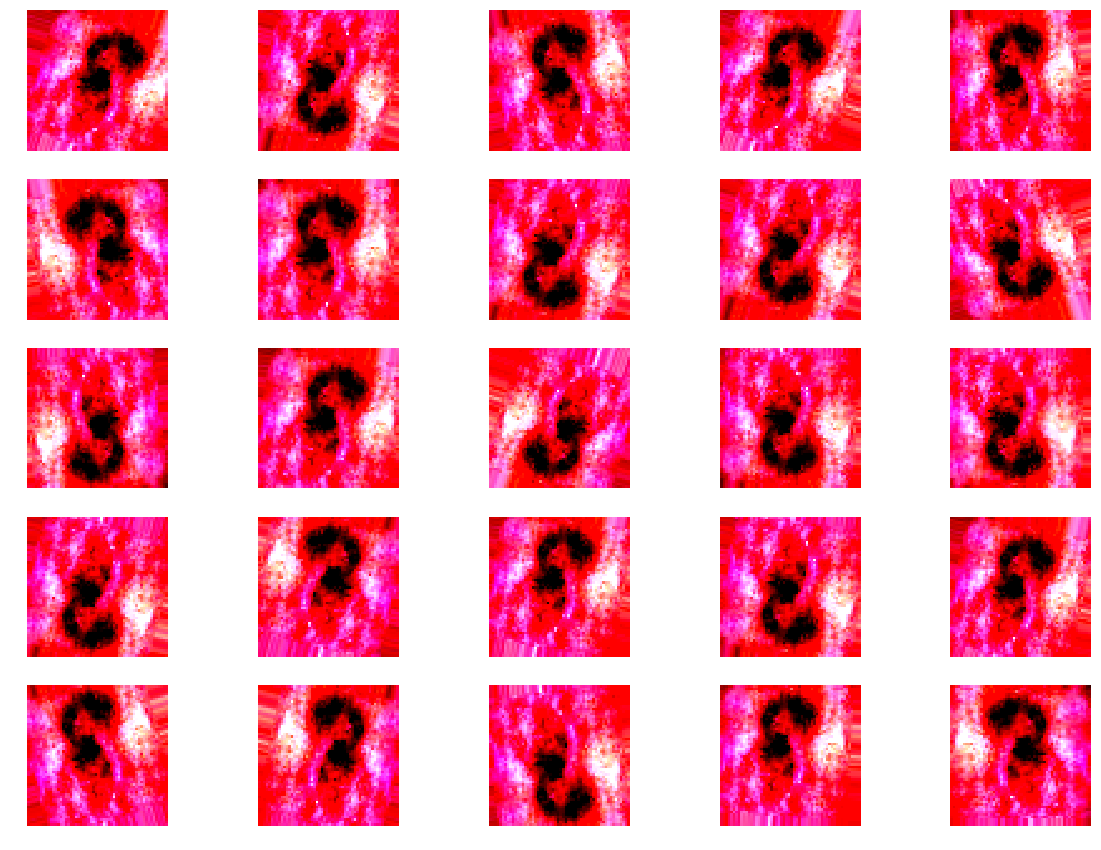

In [47]:
n_dim = 5
n_samples = n_dim**2
flower = datagen.flow(x_train[51:52], y_train[51:52], batch_size=1)

fig, all_axs = plt.subplots(n_dim, n_dim, figsize = (4*n_dim, 3*n_dim))
for row_axs in all_axs:
    for one_ax in row_axs:
        one_image = flower.next()[0][0]
        one_image[one_image>1.0] = 1.0
        one_image[one_image<0.0] = 0.0
        one_ax.imshow(one_image)
        one_ax.axis('off')

In [49]:
num_classes = 7

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [50]:
batch_size = 64
real_data_epochs = 12

x_train_std = datagen.standardize(x_train.astype('float'))
x_test_std = datagen.standardize(x_test.astype('float'))

history = model.fit(x_train_std, y_train,
        batch_size=batch_size,
        epochs=real_data_epochs,
        verbose=1,
        validation_data=(x_test_std, y_test))

Train on 9515 samples, validate on 500 samples
Epoch 1/12
9515/9515 [==============================] - 7s 780us/step - loss: 0.9907 - acc: 0.6577 - val_loss: 0.8133 - val_acc: 0.6980
Epoch 2/12
9515/9515 [==============================] - 6s 610us/step - loss: 0.8374 - acc: 0.6975 - val_loss: 0.8339 - val_acc: 0.6960
Epoch 3/12
9515/9515 [==============================] - 6s 608us/step - loss: 0.7673 - acc: 0.7159 - val_loss: 0.7310 - val_acc: 0.7300
Epoch 4/12
9515/9515 [==============================] - 6s 612us/step - loss: 0.7447 - acc: 0.7290 - val_loss: 0.6750 - val_acc: 0.7320
Epoch 5/12
9515/9515 [==============================] - 6s 608us/step - loss: 0.6850 - acc: 0.7485 - val_loss: 0.6812 - val_acc: 0.7320
Epoch 6/12
9515/9515 [==============================] - 6s 608us/step - loss: 0.6472 - acc: 0.7612 - val_loss: 0.7119 - val_acc: 0.7260
Epoch 7/12
9515/9515 [==============================] - 6s 609us/step - loss: 0.6066 - acc: 0.7762 - val_loss: 0.6712 - val_acc: 0.7380
E

In [51]:
gen_data_epochs = 24

# For some reason we get an error unless we start with model.fit before model.fit_generator
history = model.fit_generator( 
        generator=datagen.flow(x_train, y_train, batch_size=batch_size),
        steps_per_epoch=len(x_train) // gen_data_epochs,
        epochs=gen_data_epochs,
        verbose=1,
        validation_data=(x_test_std, y_test))

score = model.evaluate(x_test_std, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/24
396/396 [==============================] - 35s 87ms/step - loss: 0.7015 - acc: 0.7474 - val_loss: 0.6353 - val_acc: 0.7540
Epoch 2/24
396/396 [==============================] - 34s 86ms/step - loss: 0.6492 - acc: 0.7617 - val_loss: 0.6468 - val_acc: 0.7440
Epoch 3/24
396/396 [==============================] - 34s 87ms/step - loss: 0.6278 - acc: 0.7713 - val_loss: 0.5854 - val_acc: 0.7680
Epoch 4/24
396/396 [==============================] - 34s 86ms/step - loss: 0.6140 - acc: 0.7725 - val_loss: 0.5660 - val_acc: 0.7900
Epoch 5/24
396/396 [==============================] - 34s 87ms/step - loss: 0.5925 - acc: 0.7796 - val_loss: 0.5691 - val_acc: 0.7940
Epoch 6/24
396/396 [==============================] - 34s 86ms/step - loss: 0.5764 - acc: 0.7836 - val_loss: 0.5465 - val_acc: 0.7900
Epoch 7/24
396/396 [==============================] - 34s 85ms/step - loss: 0.5692 - acc: 0.7863 - val_loss: 0.5811 - val_acc: 0.7660
Epoch 8/24
396/396 [==============================] - 34s 86ms

In [53]:
y_pred = model.predict(x_test_std)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

Text(0,0.5,'Fraction classified incorrectly')

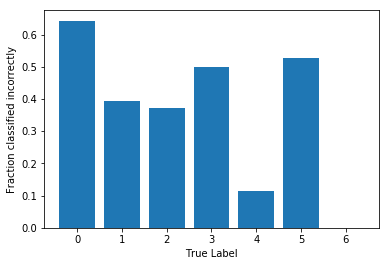

In [54]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')